In [64]:
import re
import os
from glob import glob

import pandas as pd
import numpy as np

from astropy.io import fits
from astropy.table import Table
from astropy import units as u, constants as const

from starkit.gridkit.io.process import BaseProcessGrid
from starkit.gridkit import load_grid
from scipy import ndimage as nd
from scipy.interpolate import interp1d


In [67]:
moehler_bib = """@ARTICLE{2014A&A...568A...9M,
       author = {{Moehler}, S. and {Modigliani}, A. and {Freudling}, W. and
        {Giammichele}, N. and {Gianninas}, A. and {Gonneau}, A. and
        {Kausch}, W. and {Lan{\c{c}}on}, A. and {Noll}, S. and {Rauch},
        T. and {Vinther}, J.},
        title = "{Flux calibration of medium-resolution spectra from 300 nm to 2500 nm:
        Model reference spectra and telluric correction}",
      journal = {\aap},
     keywords = {standards, techniques: spectroscopic, Astrophysics - Instrumentation and
        Methods for Astrophysics, Astrophysics - Solar and Stellar
        Astrophysics},
         year = 2014,
        month = Aug,
       volume = {568},
          eid = {A9},
        pages = {A9},
          doi = {10.1051/0004-6361/201423790},
       adsurl = {https://ui.adsabs.harvard.edu/#abs/2014A&A...568A...9M},
      adsnote = {Provided by the SAO/NASA Astrophysics Data System}
}


"""
moehler_telluric_meta = pd.Series([moehler_bib, ['airmass', 'pwv'], 'vacuum', 'Angstrom', '1'], 
                               index=[u'bibtex', u'parameters', u'wavelength_type', u'wavelength_unit', 'flux_unit'], )


In [51]:
class MoehlerTelluric(BaseProcessGrid):
    R_initial = 60000.
    R_initial_sampling=1

    def __init__(self, index, input_wavelength, meta, wavelength_start=0*u.angstrom, wavelength_stop=np.inf*u.angstrom,
                 R=None, R_sampling=4):
        super(MoehlerTelluric, self).__init__(index, input_wavelength, meta, wavelength_start=wavelength_start,
                                         wavelength_stop=wavelength_stop, R=R, R_sampling=R_sampling)
    def load_flux(self, fname):
        return Table.read(fname)['trans']
    
    def interp_wavelength(self, flux):
        cut_flux = flux[self.start_idx:self.stop_idx]
        rescaled_R = 1 / np.sqrt((1/self.R)**2 - (1/self.R_initial)**2)
        sigma = ((self.R_initial / rescaled_R) * self.R_initial_sampling
                 / (2 * np.sqrt(2 * np.log(2))))

        processed_flux = nd.gaussian_filter1d(cut_flux, sigma)
        output_flux = interp1d(self.cut_wavelength, processed_flux)(
            self.output_wavelength)
        return output_flux


#### Generating Index for Telluric Data ####

In [22]:
lbl_telluric_pattern = re.compile('LBL_A(\d\d)_s0_w(\d\d\d).+?\.fits')

In [54]:
fname_list = np.sort(glob('LBL*.fits'))
raw_index = pd.DataFrame(index=np.arange(len(fname_list)), columns=['airmass', 'pwv', 'filename'])
for i, fname in enumerate(fname_list):
    airmass, pwv = lbl_telluric_pattern.match(os.path.basename(fname)).groups()
    airmass = float(airmass) / 10.
    pwv = float(pwv) / 10.
    raw_index.iloc[i] = (airmass, pwv, fname)

In [55]:
raw_index

,airmass,pwv,filename
0,1,0.5,LBL_A10_s0_w005_R0060000_T.fits
1,1,1,LBL_A10_s0_w010_R0060000_T.fits
2,1,1.5,LBL_A10_s0_w015_R0060000_T.fits
3,1,2.5,LBL_A10_s0_w025_R0060000_T.fits
4,1,3.5,LBL_A10_s0_w035_R0060000_T.fits
5,1,5,LBL_A10_s0_w050_R0060000_T.fits
6,1,7.5,LBL_A10_s0_w075_R0060000_T.fits
7,1,10,LBL_A10_s0_w100_R0060000_T.fits
8,1,20,LBL_A10_s0_w200_R0060000_T.fits
9,1.5,0.5,LBL_A15_s0_w005_R0060000_T.fits


In [41]:
wavelength = (Table.read(fname_list[0])['lam'] * u.micron).to(u.angstrom)

In [68]:
moehler_telluric = MoehlerTelluric(raw_index, wavelength, moehler_telluric_meta, 
                           wavelength_start=3001*u.angstrom, 
                           wavelength_stop=25000*u.angstrom, R=50000,
                          R_sampling=4)

In [69]:
moehler_telluric.to_hdf('moehler_telluric.hdf')

45it [00:01, 26.35it/s]


done


In [70]:
moehler_telluric_grid = load_grid('moehler_telluric.h5')

starkit.gridkit.base - INFO - Reading index
starkit.gridkit.base - INFO - Discovered columns airmass, pwv
starkit.gridkit.base - INFO - Reading Fluxes
starkit.gridkit.base - INFO - Fluxes shape (45, 423987)
starkit.gridkit.base - INFO - Initializing spec grid
starkit.gridkit.base - INFO - Setting grid extent


Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


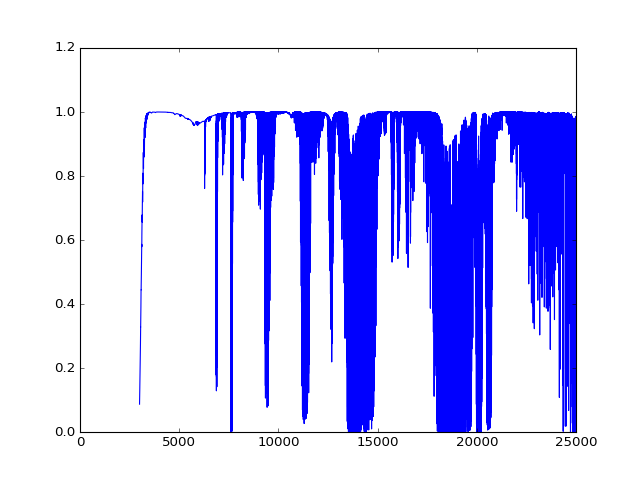

In [73]:
%pylab notebook

wave, t = moehler_telluric_grid()

plot(wave, t)